In [179]:
import numpy as np
import pandas as p
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, optimizers, regularizers
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU

In [180]:
# GET THE MNIST DATA
(x_train, y_test), (x_test, y_test) = mnist.load_data()


In [181]:
# Function to 
# 1. Change dimensions
# 2. Change datatype
def binary_preprocess(imageset):
    imageset = imageset.reshape(imageset.shape[0],28,28,1)/255.
    return np.where(imageset > .5, 1.0,0.0).astype('float32')

In [182]:
# Pre-processed images 
x_train_images = binary_preprocess(x_train)
x_test_images = binary_preprocess(x_test)

### Load MNIST dataset

### Define the kernel divergence function that comes with a weight

Will help with scaling

In [183]:
def get_kernel_divergence_fn(train_size, w=1.0):
    def kernel_divergence_fn(q, p, _): 
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

In [184]:
# Add a variable "weight" to the layer
def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

### Define the loss function of negative log-likelihood (input as logits)

In [186]:
def get_encoder(input_shape=(28,28,1), train_size=batch_size):
    model_in = Input(shape=input_shape)
    x = Flatten()(model_in)
    dense_1 = DenseFlipout(256, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = DenseFlipout(2, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model

def get_decoder():
    decoded = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(2,)),              
            tfp.layers.DenseFlipout(256, activation='relu'),            
            tfp.layers.DenseFlipout(784),
            tfp.layers.IndependentBernoulli((28,28,1), name='x_layer')
        ]
    )

    return decoded

def autoencoder(encoder,decoder):
    x_input = tf.keras.Input(shape=(28,28,1))
    encoder = get_encoder()
    decoder = get_decoder()
    z = encoder(x_input)

    # compile VAE model
    model = tf.keras.Model(inputs=x_input, outputs=decoder(z))
    model.compile(loss=negative_log_likelihood, 
                  optimizer=tf.keras.optimizers.Adam(1e-3))
    return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)



In [132]:
# Instantiate 
harencoder = get_encoder()
hardecoder = get_decoder()
model = autoencoder(harencoder,hardecoder)

In [133]:
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_18 (Functional)        (None, 2)                 402692    
_________________________________________________________________
sequential_7 (Sequential)    multiple                  202256    
Total params: 604,948
Trainable params: 604,946
Non-trainable params: 2
_________________________________________________________________


In [189]:
from tensorflow.keras.utils import plot_model

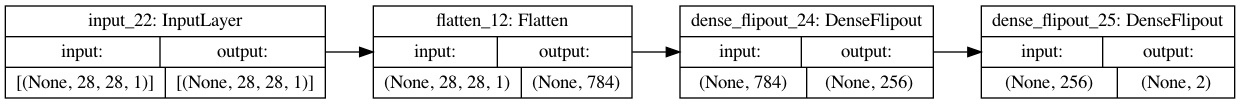

In [202]:
plot_model(harencoder,rankdir='LR',to_file = 'encoder.png',expand_nested=True,show_shapes=True)

In [134]:
batch_size = 128
n_epochs = 25
model.fit(x_train_images,x_train_images,batch_size=batch_size, epochs=n_epochs)

Epoch 1/25
469/469 [==============================] - 9s 16ms/step - loss: 4030.3700
Epoch 2/25
469/469 [==============================] - 7s 15ms/step - loss: 3263.0913
Epoch 3/25
469/469 [==============================] - 7s 15ms/step - loss: 2583.1954
Epoch 4/25
469/469 [==============================] - 7s 15ms/step - loss: 1954.8538
Epoch 5/25
469/469 [==============================] - 9s 20ms/step - loss: 1398.0047
Epoch 6/25
469/469 [==============================] - 8s 18ms/step - loss: 939.9785
Epoch 7/25
469/469 [==============================] - 7s 14ms/step - loss: 599.7790
Epoch 8/25
469/469 [==============================] - 7s 14ms/step - loss: 379.4300
Epoch 9/25
469/469 [==============================] - 7s 15ms/step - loss: 260.4977
Epoch 10/25
469/469 [==============================] - 7s 14ms/step - loss: 207.8135
Epoch 11/25
469/469 [==============================] - 7s 16ms/step - loss: 188.6275
Epoch 12/25
469/469 [==============================] - 8s 18ms/step -

Text(0.5, 0.95, 'Input Image vs Reconstruction Image')

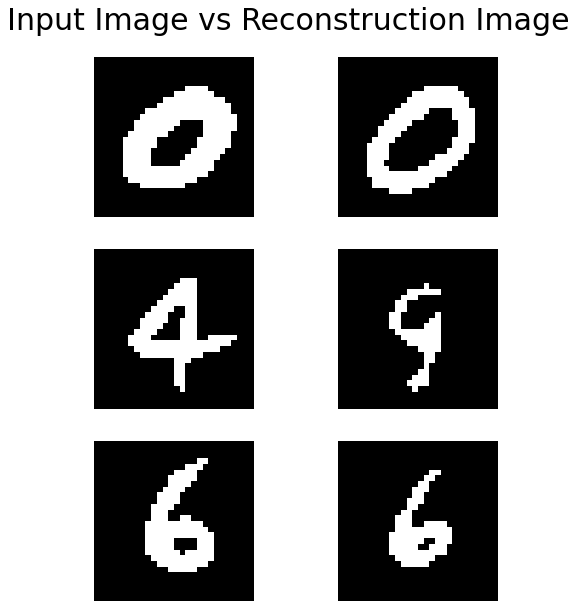

In [234]:
# Verify if there is some learning
fig, ax = plt.subplots(3,2,figsize=(8,10))


# Predictio

for i in range(3):
    test_sample = np.random.randint(0,10000)
    
    pred = model(x_test_images[test_sample:test_sample+1]).mode()
    pred = pred.numpy().squeeze()    
    ax[i,0].imshow(x_test_images[test_sample].squeeze(),cmap='gray')
    ax[i,1].imshow(pred,cmap='gray')
#     ax[i,0].set_title('True image',fontsize=14)
#     ax[i,1].set_title('Reconstruction',fontsize=14);
    ax[i,0].axis('off');
    ax[i,1].axis('off');

fig.suptitle('Input Image vs Reconstruction Image',fontsize=30,y=0.95)    
    